### Problem Statement: 

To scrap blog titles from RSS news feed from the Sports,Environment,Technology and Entertainment categories and build a classification model that classifies the blog titles into their respective categories.

### Importing Required Libraries:

In [27]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import numpy as np

from warnings import filterwarnings
filterwarnings('ignore')

### Data Scrapping:

In [2]:
df_rss=pd.DataFrame()

def rss_news(rss_link,category):
    global df_rss
    
    blog_list=[]
    
    #url of the feed 
    feed_url=rss_link
    
    #Obtaining the feed in form of text
    page=requests.get(feed_url).text
    
    #Using beautiful soup to obtain the text within the tags
    soup=BeautifulSoup(page,features='xml')
    
    blogs=soup.findAll("item")
    for b in blogs:
        title=b.find('title').text
        link = b.find('link').text
        published = b.find('pubDate').text

        blog_list_new={
            "title":title,
            "link":link,
            "published":published,
            "category":category
        }

        blog_list.append(blog_list_new)
        df_rss=df_rss.append(blog_list,ignore_index=True)
            

In [3]:
#1
rss_news("https://timesofindia.indiatimes.com/rssfeeds/4719148.cms","Sports")

In [4]:
#2
rss_news("https://timesofindia.indiatimes.com/rssfeeds/2647163.cms","Environment")

In [5]:
#3
rss_news("https://timesofindia.indiatimes.com/rssfeeds/66949542.cms","Technology")

In [6]:
#4
rss_news("https://timesofindia.indiatimes.com/rssfeeds/1081479906.cms","Entertainment")

In [7]:
df_rss.head()

,title,link,published,category
0,Olympics Live: Mary Kom knocked out after losi...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 05:13:42 IST",Sports
1,Olympics Live: Mary Kom knocked out after losi...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 05:13:42 IST",Sports
2,Djokovic cruises past Nishikori to enter Olymp...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 16:14:49 IST",Sports
3,Olympics Live: Mary Kom knocked out after losi...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 05:13:42 IST",Sports
4,Djokovic cruises past Nishikori to enter Olymp...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 16:14:49 IST",Sports


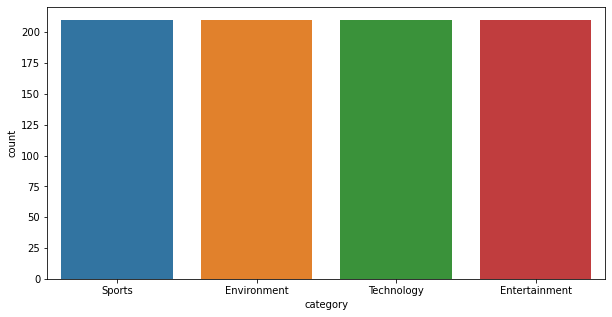

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(df_rss['category'])
plt.show()

##### As per the plot above the data is equally distributed among the 4 categories.

### Data Pre-processing:

In [9]:
df_rss.head()

,title,link,published,category
0,Olympics Live: Mary Kom knocked out after losi...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 05:13:42 IST",Sports
1,Olympics Live: Mary Kom knocked out after losi...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 05:13:42 IST",Sports
2,Djokovic cruises past Nishikori to enter Olymp...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 16:14:49 IST",Sports
3,Olympics Live: Mary Kom knocked out after losi...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 05:13:42 IST",Sports
4,Djokovic cruises past Nishikori to enter Olymp...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 16:14:49 IST",Sports


In [10]:
#Initialising Lemmatizer
lemma=WordNetLemmatizer()

#Introducing Stopwords
stop_words=stopwords.words('english')

sentence=df_rss['title']
new_sentence=[]
for i in range(len(sentence)):
    #Excluding all characters other than letters
    word=re.sub("[^a-zA-z]"," ",sentence[i])
    #Lower casing the words
    word=word.lower()
    #Splitting the sentence into tokens
    word=word.split()
    #Lemmatizing all the words excluding stop words to keep just the root word
    word=[lemma.lemmatize(w) for w in word if w not in stop_words]
    word=" ".join(word)
    new_sentence.append(word)
    
df_rss['new_title']=new_sentence
df_rss.head()

,title,link,published,category,new_title
0,Olympics Live: Mary Kom knocked out after losi...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 05:13:42 IST",Sports,olympics live mary kom knocked losing round
1,Olympics Live: Mary Kom knocked out after losi...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 05:13:42 IST",Sports,olympics live mary kom knocked losing round
2,Djokovic cruises past Nishikori to enter Olymp...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 16:14:49 IST",Sports,djokovic cruise past nishikori enter olympic semi
3,Olympics Live: Mary Kom knocked out after losi...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 05:13:42 IST",Sports,olympics live mary kom knocked losing round
4,Djokovic cruises past Nishikori to enter Olymp...,https://timesofindia.indiatimes.com/sports/tok...,"Thu, 29 Jul 2021 16:14:49 IST",Sports,djokovic cruise past nishikori enter olympic semi


### EDA:

In [11]:
new_words=[]
for i in df_rss['new_title']:
    words=i.split()
    new_words.extend(words)

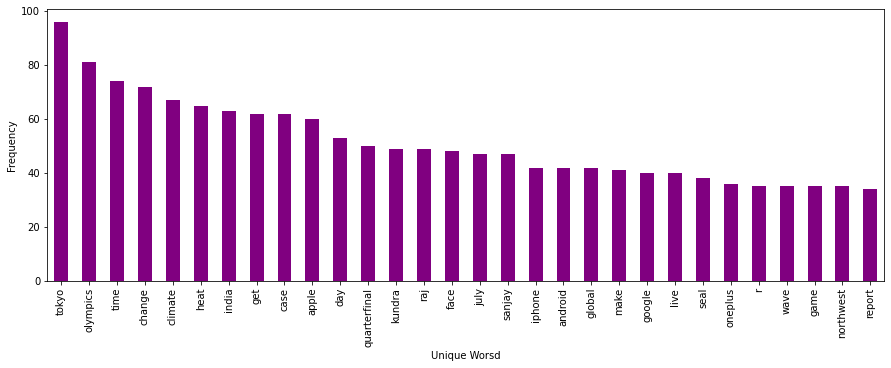

In [12]:
word_freq=pd.Series(new_words).value_counts()[:30]
plt.figure(figsize=(15,5))
word_freq.plot(kind='bar',color='purple')
plt.xlabel("Unique Worsd")
plt.ylabel("Frequency")
plt.show()

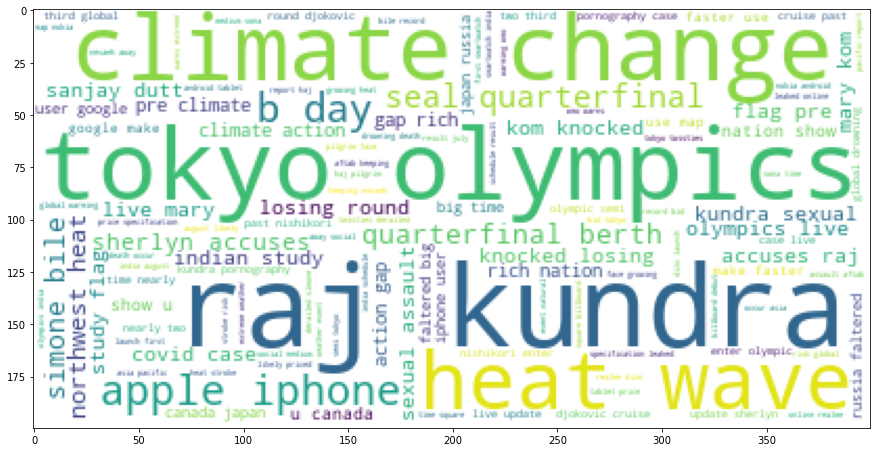

In [13]:
string_wc=" ".join(new_words)
plt.figure(figsize=(15,10))
wc=WordCloud(background_color='white').generate(string_wc)
plt.imshow(wc)
plt.show()

##### The words tokyo,change,olympics etc have the highest frequency as per the barplot above. Also the most talked about topics are about Raj Kundra,climate change,heat wave,olympics etc as per the Word Cloud.

### Spliiting Data into Train and Test: 

In [14]:
df_rss['category'].replace({'Sports':0,'Environment':1,'Technology':2,'Entertainment':3},inplace=True)
X_train,X_test,y_train,y_test=train_test_split(df_rss['new_title'],df_rss['category'],test_size=0.3,random_state=10)

### Bag of Words Model : 

In [15]:
# Using Tfidf Vectorizer to build a bag of words

tfidf=TfidfVectorizer(max_df=3).fit(X_train)

features=tfidf.get_feature_names()
train_dtm=tfidf.transform(X_train).toarray()
test_dtm=tfidf.transform(X_test).toarray()

In [16]:
# Independent Variables
df_train_dtm=pd.DataFrame(train_dtm,columns=features)
df_train_dtm.head()

,ago,agree,allegation,arctic,arjun,arvind,bug,butterfly,caeleb,chapter,...,sunny,tipping,triggered,turtle,url,used,vasisth,year,yufei,zhang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_test_dtm=pd.DataFrame(test_dtm,columns=features)
df_test_dtm.head()

,ago,agree,allegation,arctic,arjun,arvind,bug,butterfly,caeleb,chapter,...,sunny,tipping,triggered,turtle,url,used,vasisth,year,yufei,zhang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Building Classification Model:

In [18]:
# Functions to obatin scores
def train_f1(model):
    y_pred_train=model.predict(df_train_dtm)
    f1_train=f1_score(y_train,y_pred_train,average='macro')
    return f1_train

def test_f1(model):
    y_pred_test=model.predict(df_test_dtm)
    f1_test=f1_score(y_test,y_pred_test,average='macro')
    return f1_test

In [23]:
xgb=XGBClassifier()
xgb.fit(df_train_dtm,y_train)

[16:43:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
train_f1(xgb)

0.1436144462665929

In [26]:
test_f1(xgb)

0.14997727337354666

### Conclusion:

- The data was extracted from RSS news feed using BeautifulSoup.
- A bag of words model was built using Tf-IDF to convert the words to vectors.
- XGBoost classifier was used to classify the categories of the blogs.